In [41]:
from keras.datasets import boston_housing
from keras import models
from keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [153]:
# Loads data
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

In [154]:
train_data.shape

(404, 13)

In [155]:
test_data.shape

(102, 13)

In [156]:
# Prepares data

# normalizes data
train_data_mean = train_data.mean(axis=0)
train_data_std = train_data.std(axis=0)
train_data -= train_data_mean
train_data /= train_data_std

test_data -= train_data_mean
test_data /= train_data_std

# Seperates validation data
validation_samples_count = 104
x_validation = train_data[:validation_samples_count]
x_train = train_data[validation_samples_count:]

y_validation = train_labels[:validation_samples_count]
y_train = train_labels[validation_samples_count:]

In [157]:
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

In [158]:
 # Creates model
    
def create_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

In [159]:
# Trains model with Stand-out Validation

epoch_count = 100

model = create_model()
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1, epochs=epoch_count, verbose=0)

In [160]:
np.mean(history.history["val_mae"])

2.1495620143413543

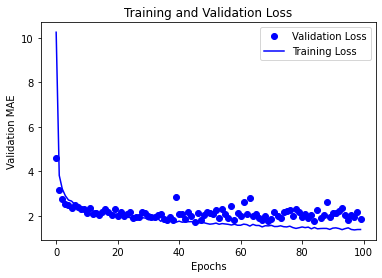

In [162]:
%matplotlib inline

plt.plot(range(epoch_count), history.history["val_mae"], "bo", label="Validation Loss")
plt.plot(range(epoch_count),history.history["mae"], "b", label="Training Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.legend()
plt.show()

In [82]:
# Now, trains model with K-Fold Validation

k_fold_validation_count = 4

def train_model(k_fold_validation_count, epoch_count):
    validation_samples_count = len(train_data)//k_fold_validation_count
    validation_mae_history = []
    for i in range(k_fold_validation_count):
        print("Processing fold #:", i)
        x_validation = train_data[i * validation_samples_count:(i+1)*validation_samples_count]
        y_validation = train_labels[i * validation_samples_count:(i+1)*validation_samples_count]

        x_train = np.concatenate(
            [train_data[:i*validation_samples_count], train_data[(i+1)*validation_samples_count:]], axis=0)
        y_train = np.concatenate(
            [train_labels[:i*validation_samples_count], train_labels[(i+1)*validation_samples_count:]], axis=0)

        model = create_model()
        history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=1, epochs=epoch_count, verbose=0)
        print("    Average validation MAE ", np.average(history.history["val_mae"]))
        #validation_mse, validation_mae = model.evaluate(x_validation, y_validation, verbose=0)
        validation_mae_history.append(history.history["val_mae"])
        
    return validation_mae_history

validation_mae_history = train_model(4, 100)

Processing fold #: 0
    Average validation MAE  3.1863036131858826
Processing fold #: 1
    Average validation MAE  2.902030429840088
Processing fold #: 2
    Average validation MAE  3.2906708216667173
Processing fold #: 3
    Average validation MAE  2.4764808440208435


Processing fold #: 0
    Average validation MAE  3.9089860172271726
Processing fold #: 1
    Average validation MAE  3.4532733001708986
Processing fold #: 2
    Average validation MAE  3.0485620350837705
Processing fold #: 3
    Average validation MAE  2.804881455898285


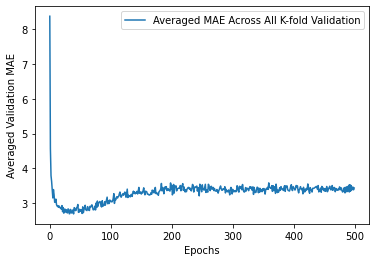

In [101]:
# Now, let's train the model over 500 epochs

k_fold_validation_count = 4
epoch_count = 500
validation_mae_history = train_model(4, epoch_count)
averaged_mae_across_all_k_fold_validation = np.mean(validation_mae_history, axis=0)

plt.plot(range(epoch_count), averaged_mae_across_all_k_fold_validation, label="Averaged MAE Across All K-fold Validation")
plt.xlabel("Epochs")
plt.ylabel("Averaged Validation MAE")
plt.legend()
plt.show()

In [146]:
# It is difficult to realize the above plat due to MAE scaling issue.
# It seems validation MAE is lowest at some epoch between 0 to 100.
# Let's get that epoch from history

epoch = np.where(averaged_mae_across_all_k_fold_validation == averaged_mae_across_all_k_fold_validation.min())

In [148]:
epoch[0]

array([39])

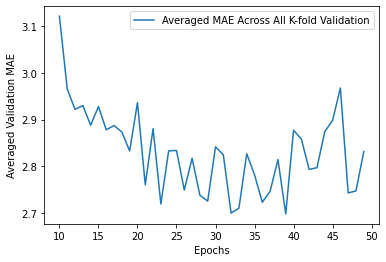

In [150]:
# So, validation MAE is lowest at epoch 39
# Now, zoom in into the plot in range 10 to 50

plt.plot(range(10, 50), averaged_mae_across_all_k_fold_validation[10:50], label="Averaged MAE Across All K-fold Validation")
plt.xlabel("Epochs")
plt.ylabel("Averaged Validation MAE")
plt.legend()
plt.show()

In [171]:
# Let's now build the final model by (1) combining validation data back into training data (2) with 39 epochs.

model = create_model()
model.fit(train_data, train_labels, epochs=39, batch_size=1)
test_mse, test_mae = model.evaluate(test_data, test_labels)

Epoch 1/39
404/404 [==============================] - 1s 3ms/step - loss: 162.5955 - mae: 9.0326
Epoch 2/39
404/404 [==============================] - 1s 3ms/step - loss: 22.4669 - mae: 3.2685
Epoch 3/39
404/404 [==============================] - 1s 3ms/step - loss: 17.4502 - mae: 2.8103
Epoch 4/39
404/404 [==============================] - 1s 3ms/step - loss: 14.7331 - mae: 2.5243
Epoch 5/39
404/404 [==============================] - 1s 3ms/step - loss: 13.4620 - mae: 2.5153
Epoch 6/39
404/404 [==============================] - 1s 3ms/step - loss: 12.7881 - mae: 2.4289
Epoch 7/39
404/404 [==============================] - 1s 3ms/step - loss: 12.0055 - mae: 2.4271
Epoch 8/39
404/404 [==============================] - 1s 3ms/step - loss: 11.4202 - mae: 2.2829
Epoch 9/39
404/404 [==============================] - 1s 3ms/step - loss: 11.2058 - mae: 2.2615
Epoch 10/39
404/404 [==============================] - 1s 3ms/step - loss: 10.3613 - mae: 2.1557
Epoch 11/39
404/404 [=================

In [172]:
print("Test MSE:", test_mse, ", Test MAE:", test_mae)

Test MSE: 17.438547134399414 , Test MAE: 2.6858274936676025
